In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
!pip install matplotlib --quiet

In [30]:
!pip install hmmlearn --quiet

In [31]:
# Import libraries for data manipulation and analysis
import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
import matplotlib.pyplot as plt

In [32]:
# Read datafile
data = pd.read_csv('/content/drive/MyDrive/PTDLKD/Data/Silver_Data.csv')
data=data.set_index(pd.DatetimeIndex(data['Date'].values))

# Preprocessing

---



In [33]:
# Flip the column
data = data.iloc[::-1]

# Format column Date
data.Date = pd.to_datetime(data.Date,format='%m/%d/%Y')

# Drop column that aren't use
data.drop(['Open', 'High', 'Low', 'Vol.', 'Change %'], axis = 1, inplace=True)


# Spilt Dataset (7-2-1)

---



In [34]:
# Just use the Price
df = data

train_size = int(.7*len(df))
test_size = int(.2*len(df))
val_size = len(df) - train_size - test_size

Price_7_2_1 = df['Price'].values.reshape(-1, 1)

split_1_3 = 1/3

# Split the data into training, testing, and validation sets
train_data, temp_data = train_test_split(Price_7_2_1, test_size=0.3, random_state=42) # tran: 70%Data, temp: 30%Data
test_data, validate_data = train_test_split(temp_data, test_size=split_1_3, random_state=42) # test: 2/3temp, val: 1/3temp

train_size = len(train_data)
test_size = len(test_data)
val_size = len(validate_data)

# Create and train HMM model with training set
model = GaussianHMM(n_components=3, covariance_type='diag', n_iter=1000)
model.fit(train_data)

# Predict hidden state for train, test set
hidden_states_train = model.predict(train_data)
hidden_states_test = model.predict(test_data)
hidden_states_val = model.predict(validate_data)

In [35]:
# Predict 30 days
new_index = pd.date_range(start=df.index[-1], periods=31, freq='D')[1:]
df1 = df.reindex(df.index.union(new_index))

df1.fillna(0, inplace=True)

prices_last_30 = df1['Price'].values.reshape(-1, 1)

predicted_states = model.predict(prices_last_30[-30:])
predicted_prices = [model.means_[int(state)][0] for state in predicted_states]
print(predicted_prices)

[24.222751182461447, 16.86325877396974, 16.86325877396974, 16.86325877396974, 16.86325877396974, 16.86325877396974, 16.86325877396974, 16.86325877396974, 16.86325877396974, 16.86325877396974, 16.86325877396974, 16.86325877396974, 16.86325877396974, 16.86325877396974, 16.86325877396974, 16.86325877396974, 16.86325877396974, 16.86325877396974, 16.86325877396974, 16.86325877396974, 16.86325877396974, 16.86325877396974, 16.86325877396974, 16.86325877396974, 16.86325877396974, 16.86325877396974, 16.86325877396974, 16.86325877396974, 16.86325877396974, 16.86325877396974]


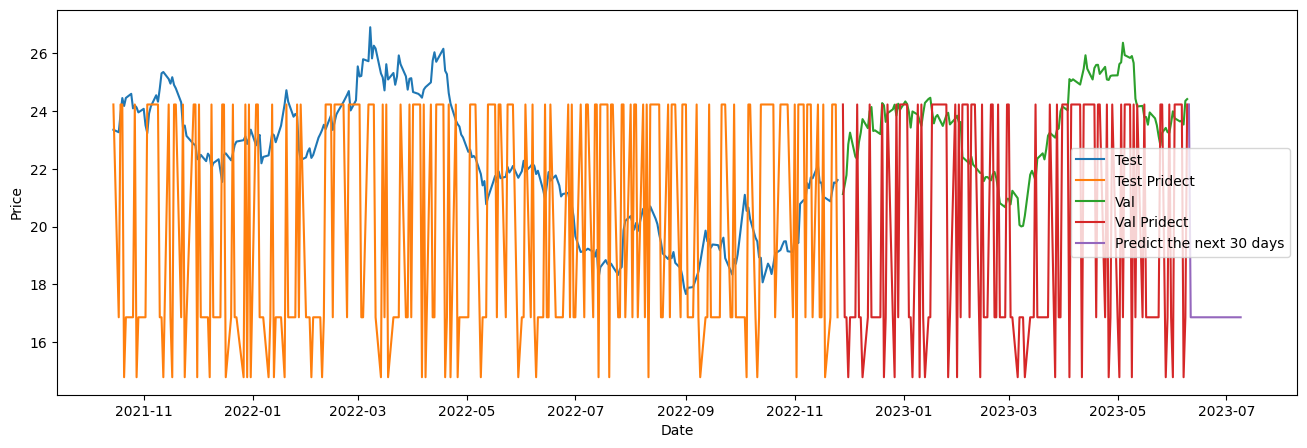

In [36]:
train = df[:train_size]
test = df[train_size:train_size+test_size]
validate = df[train_size+test_size:]

# Plot the model
plt.figure(figsize=(16,5))

plt.plot(test.index, test.Price, label='Test')
plt.plot(test.index, [model.means_[state][0] for state in hidden_states_test], label='Test Pridect')
plt.plot(validate.index, validate.Price, label='Val')
plt.plot(validate.index, [model.means_[state][0] for state in hidden_states_val], label='Val Pridect')
plt.plot(df1.index[-30:], predicted_prices, label='Predict the next 30 days')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [37]:
# # Calculate accuracy for each model
rmse = np.sqrt(mean_squared_error(test_data, [model.means_[state][0] for state in hidden_states_test]))
mape = mean_absolute_percentage_error(test_data, [model.means_[state][0] for state in hidden_states_test]) * 100
mae = mean_absolute_error(test_data, [model.means_[state][0] for state in hidden_states_test])

print("** Test **")
print("RMSE:", rmse)
print("MAPE:", mape)
print("MAE:", mae)

rmse = np.sqrt(mean_squared_error(validate_data, [model.means_[state][0] for state in hidden_states_val]))
mape = mean_absolute_percentage_error(validate_data, [model.means_[state][0] for state in hidden_states_val]) * 100
mae = mean_absolute_error(validate_data, [model.means_[state][0] for state in hidden_states_val])

print("** Validate **")
print("RMSE:", rmse)
print("MAPE:", mape)
print("MAE:", mae)

** Test **
RMSE: 1.749348724381238
MAPE: 6.523574044437286
MAE: 1.3410417730204616
** Validate **
RMSE: 1.3928571892575894
MAPE: 5.343112392735902
MAE: 1.0841949868912424


In [38]:
#########################################

In [39]:
train_states = pd.unique(hidden_states_train)
print("Train states:",train_states)

test_states = pd.unique(hidden_states_test)
print("Test states:",test_states)

val_states = pd.unique(hidden_states_val)
print("val states:",val_states)

Train states: [0 2 1]
Test states: [0 2 1]
val states: [0 2 1]


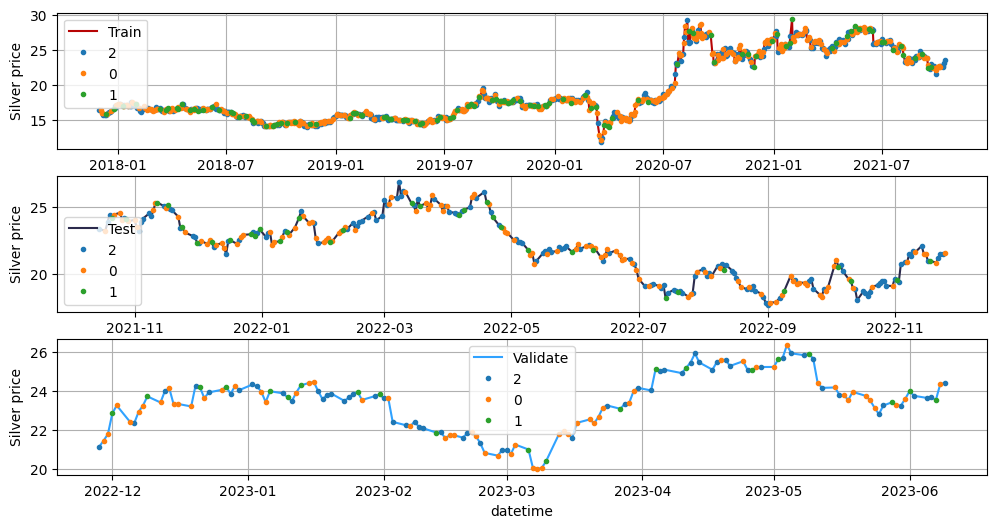

In [40]:
train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]

plt.figure(figsize=(12, 6))
plt.subplot(3,1,1)
plt.plot(train_data.Date, train_data.Price, '-', color="#B70404")
for i in train_states:
    want = (hidden_states_train == i)
    x = train_data.Date.iloc[want]
    y = train_data.Price.iloc[want]
    plt.plot(x, y, '.')
plt.legend(["Train",2,0,1])
plt.grid(True)
plt.xlabel("datetime")
plt.ylabel("Silver price")

plt.subplot(3,1,2)
plt.plot(test_data.Date, test_data.Price, '-', color="#2B2A4C", label='Test')
for i in test_states:
    want = (hidden_states_test == i)
    x = test_data.Date.iloc[want]
    y = test_data.Price.iloc[want]
    plt.plot(x, y, '.')
plt.legend(["Test",2,0,1])
plt.grid(True)
plt.xlabel("datetime")
plt.ylabel("Silver price")

plt.subplot(3,1,3)
plt.plot(val_data.Date, val_data.Price, '-', color="#30A2FF", label='Validate')
for i in val_states:
    want = (hidden_states_val == i)
    x = val_data.Date.iloc[want]
    y = val_data.Price.iloc[want]
    plt.plot(x, y, '.')
plt.legend(["Validate",2,0,1])
plt.grid(True)
plt.xlabel("datetime")
plt.ylabel("Silver price")
plt.show()

# Spilt Dataset (6-3-1)

---



In [41]:
# Just use the Price
df = data

Price_7_2_1 = df['Price'].values.reshape(-1, 1)

split_1_4 = 0.25

# Split the data into training, testing, and validation sets
train_data, temp_data = train_test_split(Price_7_2_1, test_size=0.4, random_state=42) # tran: 60%Data, temp: 40%Data
test_data, validate_data = train_test_split(temp_data, test_size=split_1_4, random_state=42) # test: 3/4temp, val: 1/4temp

train_size = len(train_data)
test_size = len(test_data)
val_size = len(validate_data)

# Create and train HMM model with training set
model = GaussianHMM(n_components=3, covariance_type='diag', n_iter=1000)
model.fit(train_data)

# Predict hidden state for train, test set
hidden_states_train = model.predict(train_data)
hidden_states_test = model.predict(test_data)
hidden_states_val = model.predict(validate_data)

In [42]:
# Predict 30 days
new_index = pd.date_range(start=df.index[-1], periods=31, freq='D')[1:]
df1 = df.reindex(df.index.union(new_index))

df1.fillna(0, inplace=True)

prices_last_30 = df1['Price'].values.reshape(-1, 1)

predicted_states = model.predict(prices_last_30[-30:])
predicted_prices = [model.means_[int(state)][0] for state in predicted_states]
print(predicted_prices)

[21.3439344120787, 21.3439344120787, 21.3439344120787, 21.3439344120787, 21.3439344120787, 21.3439344120787, 21.3439344120787, 21.3439344120787, 21.3439344120787, 21.3439344120787, 21.3439344120787, 21.3439344120787, 21.3439344120787, 21.3439344120787, 21.3439344120787, 21.3439344120787, 21.3439344120787, 21.3439344120787, 21.3439344120787, 21.3439344120787, 21.3439344120787, 21.3439344120787, 21.3439344120787, 21.3439344120787, 21.3439344120787, 21.3439344120787, 21.3439344120787, 21.3439344120787, 21.3439344120787, 21.3439344120787]


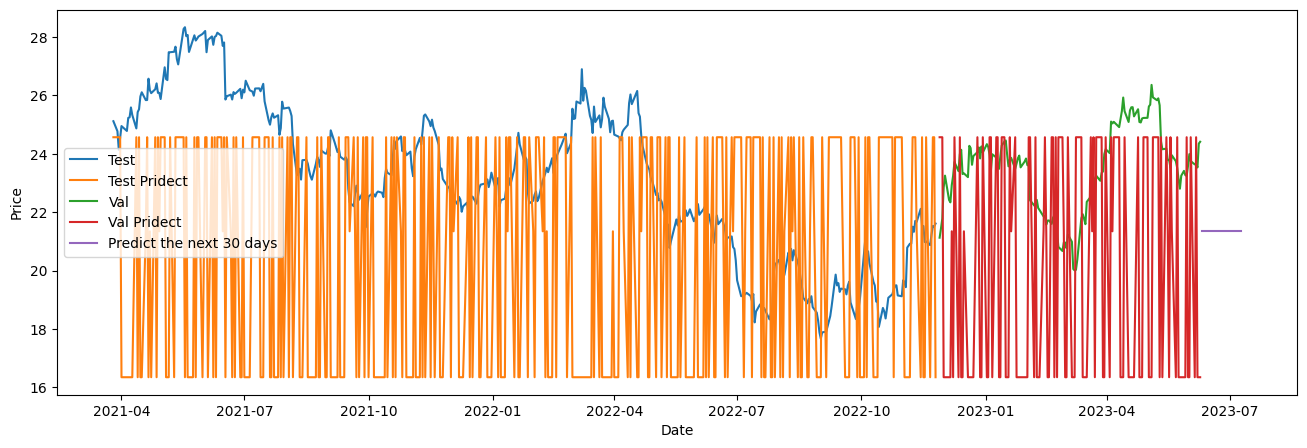

In [43]:
train = df[:train_size]
test = df[train_size:train_size+test_size]
validate = df[train_size+test_size:]

# Plot the model
plt.figure(figsize=(16,5))

plt.plot(test.index, test.Price, label='Test')
plt.plot(test.index, [model.means_[state][0] for state in hidden_states_test], label='Test Pridect')
plt.plot(validate.index, validate.Price, label='Val')
plt.plot(validate.index, [model.means_[state][0] for state in hidden_states_val], label='Val Pridect')
plt.plot(df1.index[-30:], predicted_prices, label='Predict the next 30 days')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [44]:
# # Calculate accuracy for each model
rmse = np.sqrt(mean_squared_error(test_data, [model.means_[state][0] for state in hidden_states_test]))
mape = mean_absolute_percentage_error(test_data, [model.means_[state][0] for state in hidden_states_test]) * 100
mae = mean_absolute_error(test_data, [model.means_[state][0] for state in hidden_states_test])

print("** Test **")
print("RMSE:", rmse)
print("MAPE:", mape)
print("MAE:", mae)

rmse = np.sqrt(mean_squared_error(validate_data, [model.means_[state][0] for state in hidden_states_val]))
mape = mean_absolute_percentage_error(validate_data, [model.means_[state][0] for state in hidden_states_val]) * 100
mae = mean_absolute_error(validate_data, [model.means_[state][0] for state in hidden_states_val])

print("** Validate **")
print("RMSE:", rmse)
print("MAPE:", mape)
print("MAE:", mae)

** Test **
RMSE: 1.6137335725917514
MAPE: 6.6972580640215105
MAE: 1.3172142177437074
** Validate **
RMSE: 1.6085685411287531
MAPE: 6.721619016786303
MAE: 1.2472236866687305


In [45]:
#########################################3

In [46]:
train_states = pd.unique(hidden_states_train)
print("Train states:",train_states)

test_states = pd.unique(hidden_states_test)
print("Test states:",test_states)

val_states = pd.unique(hidden_states_val)
print("val states:",val_states)

Train states: [1 0 2]
Test states: [1 0 2]
val states: [1 0 2]


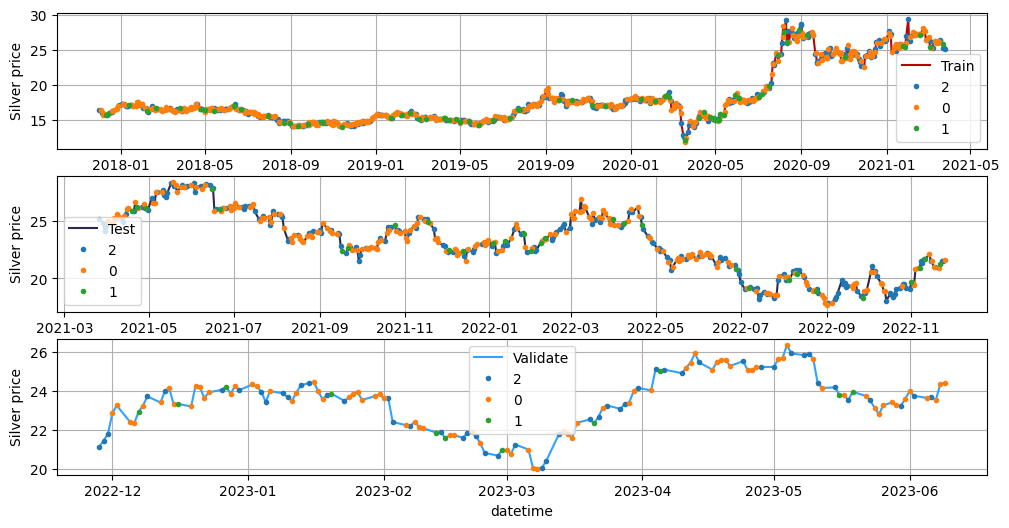

In [47]:
train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]

plt.figure(figsize=(12, 6))
plt.subplot(3,1,1)
plt.plot(train_data.Date, train_data.Price, '-', color="#B70404")
for i in train_states:
    want = (hidden_states_train == i)
    x = train_data.Date.iloc[want]
    y = train_data.Price.iloc[want]
    plt.plot(x, y, '.')
plt.legend(["Train",2,0,1])
plt.grid(True)
plt.xlabel("datetime")
plt.ylabel("Silver price")

plt.subplot(3,1,2)
plt.plot(test_data.Date, test_data.Price, '-', color="#2B2A4C", label='Test')
for i in test_states:
    want = (hidden_states_test == i)
    x = test_data.Date.iloc[want]
    y = test_data.Price.iloc[want]
    plt.plot(x, y, '.')
plt.legend(["Test",2,0,1])
plt.grid(True)
plt.xlabel("datetime")
plt.ylabel("Silver price")

plt.subplot(3,1,3)
plt.plot(val_data.Date, val_data.Price, '-', color="#30A2FF", label='Validate')
for i in val_states:
    want = (hidden_states_val == i)
    x = val_data.Date.iloc[want]
    y = val_data.Price.iloc[want]
    plt.plot(x, y, '.')
plt.legend(["Validate",2,0,1])
plt.grid(True)
plt.xlabel("datetime")
plt.ylabel("Silver price")
plt.show()

# Spilt Dataset (5-3-2)

---



In [48]:
# Just use the Price
df = data

Price_7_2_1 = df['Price'].values.reshape(-1, 1)

split_1_3 = 1/3

# Split the data into training, testing, and validation sets
train_data, temp_data = train_test_split(Price_7_2_1, test_size=0.5, random_state=42) # tran: 50%Data, temp: 50%Data
test_data, validate_data = train_test_split(temp_data, test_size=split_1_3, random_state=42) # test: 3/5temp, val: 2/5temp

train_size = len(train_data)
test_size = len(test_data)
val_size = len(validate_data)

# Create and train HMM model with training set
model = GaussianHMM(n_components=3, covariance_type='diag', n_iter=1000)
model.fit(train_data)

# Predict hidden state for train, test set
hidden_states_train = model.predict(train_data)
hidden_states_test = model.predict(test_data)
hidden_states_val = model.predict(validate_data)

In [49]:
# Predict 30 days
new_index = pd.date_range(start=df.index[-1], periods=31, freq='D')[1:]
df1 = df.reindex(df.index.union(new_index))

df1.fillna(0, inplace=True)

prices_last_30 = df1['Price'].values.reshape(-1, 1)

predicted_states = model.predict(prices_last_30[-30:])
predicted_prices = [model.means_[int(state)][0] for state in predicted_states]
print(predicted_prices)

[17.010229671445696, 24.273662319862296, 24.273662319862296, 24.273662319862296, 24.273662319862296, 24.273662319862296, 24.273662319862296, 24.273662319862296, 24.273662319862296, 24.273662319862296, 24.273662319862296, 24.273662319862296, 24.273662319862296, 24.273662319862296, 24.273662319862296, 24.273662319862296, 24.273662319862296, 24.273662319862296, 24.273662319862296, 24.273662319862296, 24.273662319862296, 24.273662319862296, 24.273662319862296, 24.273662319862296, 24.273662319862296, 24.273662319862296, 24.273662319862296, 24.273662319862296, 24.273662319862296, 24.273662319862296]


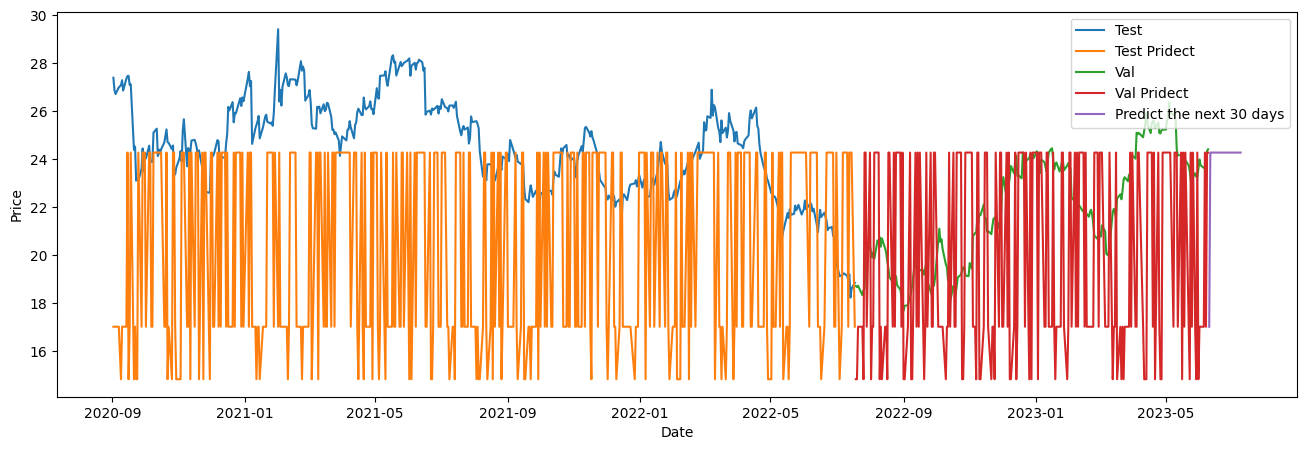

In [50]:
train = df[:train_size]
test = df[train_size:train_size+test_size]
validate = df[train_size+test_size:]

# Plot the model
plt.figure(figsize=(16,5))

plt.plot(test.index, test.Price, label='Test')
plt.plot(test.index, [model.means_[state][0] for state in hidden_states_test], label='Test Pridect')
plt.plot(validate.index, validate.Price, label='Val')
plt.plot(validate.index, [model.means_[state][0] for state in hidden_states_val], label='Val Pridect')
plt.plot(df1.index[-30:], predicted_prices, label='Predict the next 30 days')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [51]:
# # Calculate accuracy for each model
rmse = np.sqrt(mean_squared_error(test_data, [model.means_[state][0] for state in hidden_states_test]))
mape = mean_absolute_percentage_error(test_data, [model.means_[state][0] for state in hidden_states_test]) * 100
mae = mean_absolute_error(test_data, [model.means_[state][0] for state in hidden_states_test])

print("** Test **")
print("RMSE:", rmse)
print("MAPE:", mape)
print("MAE:", mae)

rmse = np.sqrt(mean_squared_error(validate_data, [model.means_[state][0] for state in hidden_states_val]))
mape = mean_absolute_percentage_error(validate_data, [model.means_[state][0] for state in hidden_states_val]) * 100
mae = mean_absolute_error(validate_data, [model.means_[state][0] for state in hidden_states_val])

print("** Validate **")
print("RMSE:", rmse)
print("MAPE:", mape)
print("MAE:", mae)

** Test **
RMSE: 1.6544299055788296
MAPE: 6.0926652703786015
MAE: 1.2518617988331076
** Validate **
RMSE: 1.5211822413057619
MAPE: 5.442945943123185
MAE: 1.1217587228093875


In [52]:
#########################################3

In [53]:
train_states = pd.unique(hidden_states_train)
print("Train states:",train_states)

test_states = pd.unique(hidden_states_test)
print("Test states:",test_states)

val_states = pd.unique(hidden_states_val)
print("val states:",val_states)

Train states: [0 1 2]
Test states: [2 0 1]
val states: [0 2 1]


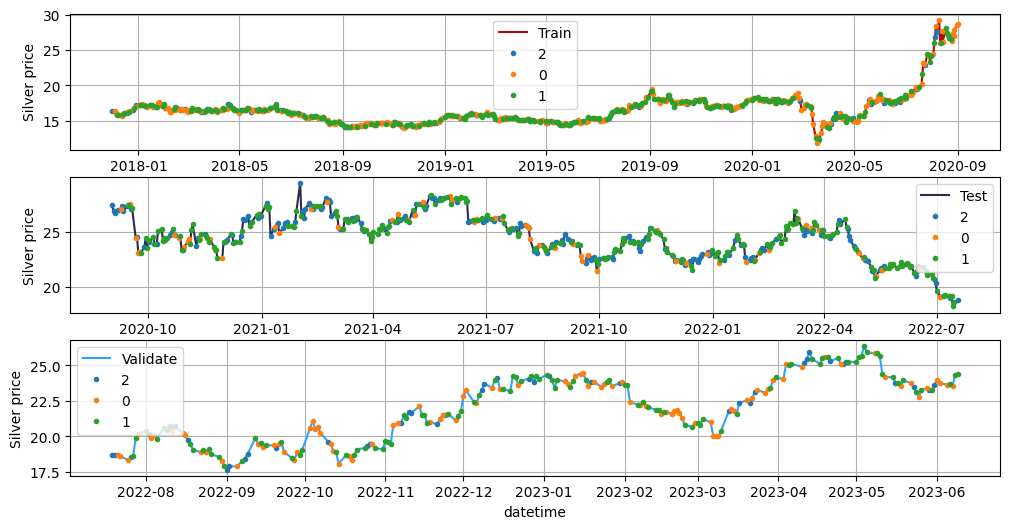

In [54]:
train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]

plt.figure(figsize=(12, 6))
plt.subplot(3,1,1)
plt.plot(train_data.Date, train_data.Price, '-', color="#B70404")
for i in train_states:
    want = (hidden_states_train == i)
    x = train_data.Date.iloc[want]
    y = train_data.Price.iloc[want]
    plt.plot(x, y, '.')
plt.legend(["Train",2,0,1])
plt.grid(True)
plt.xlabel("datetime")
plt.ylabel("Silver price")

plt.subplot(3,1,2)
plt.plot(test_data.Date, test_data.Price, '-', color="#2B2A4C", label='Test')
for i in test_states:
    want = (hidden_states_test == i)
    x = test_data.Date.iloc[want]
    y = test_data.Price.iloc[want]
    plt.plot(x, y, '.')
plt.legend(["Test",2,0,1])
plt.grid(True)
plt.xlabel("datetime")
plt.ylabel("Silver price")

plt.subplot(3,1,3)
plt.plot(val_data.Date, val_data.Price, '-', color="#30A2FF", label='Validate')
for i in val_states:
    want = (hidden_states_val == i)
    x = val_data.Date.iloc[want]
    y = val_data.Price.iloc[want]
    plt.plot(x, y, '.')
plt.legend(["Validate",2,0,1])
plt.grid(True)
plt.xlabel("datetime")
plt.ylabel("Silver price")
plt.show()

# Evaluate model

---
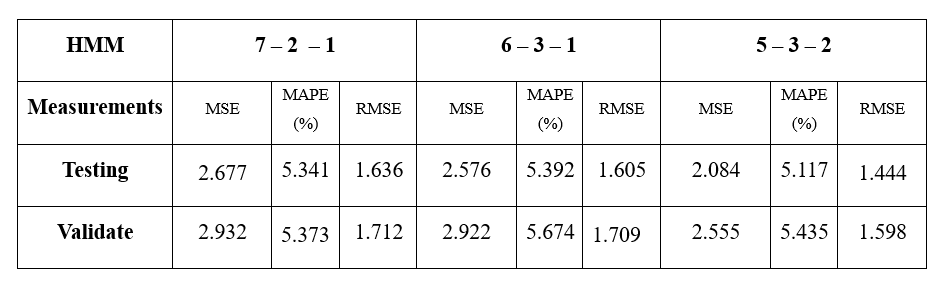
